<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Language-Model-Tutorial" data-toc-modified-id="Language-Model-Tutorial-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Language Model Tutorial</a></span><ul class="toc-item"><li><span><a href="#Getting-Started" data-toc-modified-id="Getting-Started-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Getting Started</a></span></li><li><span><a href="#Our-Data" data-toc-modified-id="Our-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Our Data</a></span></li><li><span><a href="#Counting" data-toc-modified-id="Counting-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Counting</a></span><ul class="toc-item"><li><span><a href="#Counting-Unigrams" data-toc-modified-id="Counting-Unigrams-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Counting Unigrams</a></span></li><li><span><a href="#Counting-N-grams" data-toc-modified-id="Counting-N-grams-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Counting N-grams</a></span></li><li><span><a href="#Predicting-N-grams" data-toc-modified-id="Predicting-N-grams-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Predicting N-grams</a></span></li><li><span><a href="#Generating-N-grams!-Making-the-Language-Model-speak" data-toc-modified-id="Generating-N-grams!-Making-the-Language-Model-speak-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Generating N-grams! Making the Language Model speak</a></span></li></ul></li><li><span><a href="#N-gram-Language-Models" data-toc-modified-id="N-gram-Language-Models-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>N-gram Language Models</a></span><ul class="toc-item"><li><span><a href="#Smoothing" data-toc-modified-id="Smoothing-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Smoothing</a></span></li></ul></li></ul></li><li><span><a href="#Challenge-Exercises" data-toc-modified-id="Challenge-Exercises-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Challenge Exercises</a></span></li></ul></div>

# Language Model Tutorial

**Instructions**: 
In this tutorial, we will be creating an **n-gram language model** from scratch and using the language model in a variety of applications. 

Throughout this notebook, there will be a few **bolded** questions. These are questions for you to think about, and perhaps write some code to answer as well.

## Getting Started

To start, let's import a set of libraries we will find useful later on.

In [21]:
%matplotlib inline  

# for manipulating data
from collections import Counter
from collections import defaultdict
import numpy as np
import re

# useful nlp methods
import nltk
from nltk import word_tokenize
from nltk import ngrams
from nltk.lm.preprocessing import padded_everygram_pipeline
nltk.download('punkt')

# plotting
import matplotlib
import matplotlib.pyplot as plt

#printing
from tabulate import tabulate

# downloading data
from urllib import request

# a function to flatten a list
flatten_list = lambda l: [item for sublist in l for item in sublist]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aditi_khullar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Our Data
To start, we'll be working with the [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus), a collection of English-language texts from 500 different sources grouped in 15 different categories.(e.g. fiction, news, ... etc.)

In [5]:
url = 'http://www.sls.hawaii.edu/bley-vroman/brown_nolines.txt'
response = request.urlopen(url)
raw = response.read().decode('utf8')

In [6]:
raw[0:400]

'The Fulton County Grand Jury said Friday an investigation of Atlanta\'s recent primary election produced "no evidence" that any irregularities took place.   \r\nThe jury further said in term-end presentments that the City Executive Committee, which had over-all charge of the election, "deserves the praise and thanks of the City of Atlanta" for the manner in which the election was conducted.\r\n\r\nThe Se'

This file contains a set of newline-separated ("\r\n") sentences. In addition, on manual observation, we notice some lines are not broken into sentences perfectly. We will also split on ". " as a crude way of catching these cases.

In [7]:
raw_sentences = raw.split('\r\n') # split by newline
print('--Example line with multiple sentences--')
print(raw_sentences[400]) # example line with a period in it

raw_sentences = [re.split(r'(?<=\.) ', sentence) for sentence in raw_sentences] # split by ". "
raw_sentences = flatten_list(raw_sentences)

print()
print('--Sample sentences--')
for i in range(5):
     print('>> sentence {}:'.format(i), raw_sentences[i])

--Example line with multiple sentences--
There has been more activity across the state line in Massachusetts than in Rhode Island in recent weeks toward enforcement of the Sunday sales laws. The statutes, similar in both the Bay State and Rhode Island and dating back in some instances to colonial times, severely limit the types of merchandise that may be sold on the Sabbath.   

--Sample sentences--
>> sentence 0: The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced "no evidence" that any irregularities took place.
>> sentence 1:   
>> sentence 2: The jury further said in term-end presentments that the City Executive Committee, which had over-all charge of the election, "deserves the praise and thanks of the City of Atlanta" for the manner in which the election was conducted.
>> sentence 3: 
>> sentence 4: The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible "irr

Here we note two things:

1. Some sentences are blank (e.g. sentences 1 and 3). We'll want to remove those.
2. Some words are capitalized while others are not. Some are proper nouns while others are the beginning of sentences. To help standardize this, let's lowercase all of the words (e.g. "Only" at the beginning of a sentence and "only" in the middle of a sentence are still the same).

In order to build a language model. We also need to be able to split a sentence into words. Thankfully, there's a function from nltk called word_tokenize that can do this for us.

In [8]:
def preprocess_sentence(s):
    # remove trailing whitespace
    s = s.strip()
    
    # lowercase all tokens
    s = s.lower()
    
    # split into tokens - TODO: this requires installing "punkt". Perhaps we should make a version that doesn't require installing anything
    s = word_tokenize(s)
    
    return s

# preprocess each sentence and also remove empty sentences
tokenized_sentences = [preprocess_sentence(s) for s in raw_sentences]
tokenized_sentences = [s for s in tokenized_sentences if len(s) > 0]

# print sample sentences
print('We have {} sentences in total.'.format(len(tokenized_sentences)))
print()
print('--Sample sentences--')
for i in range(5):
    print('>> sentence {}:'.format(i), tokenized_sentences[i])
    print()

We have 50238 sentences in total.

--Sample sentences--
>> sentence 0: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'atlanta', "'s", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']

>> sentence 1: ['the', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'city', 'executive', 'committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'city', 'of', 'atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']

>> sentence 2: ['the', 'september-october', 'term', 'jury', 'had', 'been', 'charged', 'by', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'mayo

This is starting to look good. Again we'll point out a few things:

1. Punctuation are their own tokens. Sometimes we will also choose to remove punctuation completely from our sentences. In . this example, we'll keep it for simplicity. 
2. As we'll see in the section below, tokenizing our sentences in this way makes it really easy to count n-grams moving forward.

Note that you can also work with the **brown corpus available in the nltk library**. Above we started by using the raw corpus. NLTK pprovides you a handle on the words and sentences direcly. 

In [9]:
from nltk.corpus import brown
#words
nltk_words = brown.words()
#sentences
nltk_sents = brown.sents()

---

Below we provide two other corpus options that you can work with for creating a language model

**Corpus Option 1:**

Lets look at the various categories covered in Brown corpus. It will be interesting to note how the language model you create changes when you limit the underlying dataset to only couple of these categories. 

In [10]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [11]:
nltk_sents = brown.sents(categories=['news', 'editorial', 'reviews'])
#words
nltk_words = brown.words(categories=['news', 'editorial', 'reviews'])
#sentences
nltk_sents = brown.sents(categories=['news', 'editorial', 'reviews'])

**Corpus Option 2:**

We can also create a languge model on Macbeth's script. Do you think a Language model trained on Macbeth will be any different?

In [12]:
from nltk.corpus import gutenberg
#words
macbeth_words = gutenberg.words('shakespeare-macbeth.txt')
#sentences
macbeth_sents = gutenberg.sents('shakespeare-macbeth.txt')

***

## Counting

### Counting Unigrams

Before we get into counting n=grams, let's do something a little simpler. What are the most common words (or "unigrams") in our corpus?

In [28]:
word_counter = Counter()
for sentence in tokenized_sentences:
    for word in sentence:
        word_counter[word] += 1
print(tabulate([[item[0],item[1]] for item in word_counter.most_common(n=10)], headers = ['Unigram', 'count']))

Unigram      count
---------  -------
the          69924
,            58328
.            48646
of           36406
and          28834
to           26095
a            23370
in           21335
that         10773
is           10191


As one might expect, we see words like "the", "of", "and"... etc. We can also plot this to see the relative frequencies.

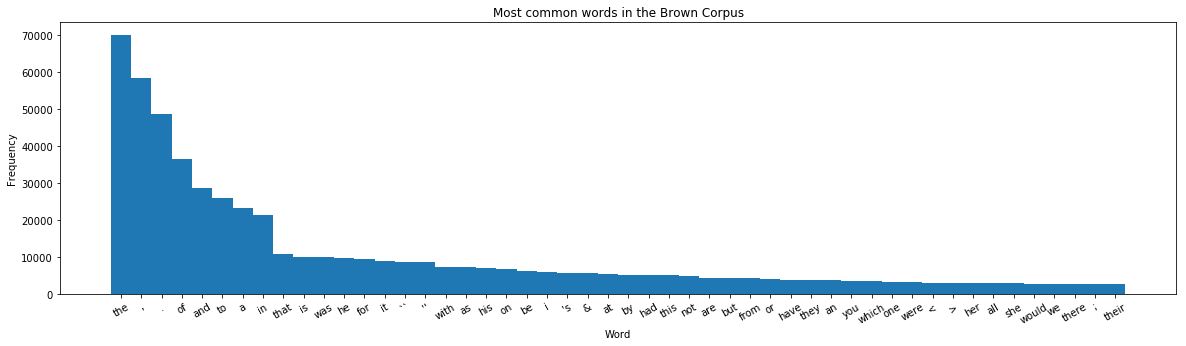

In [47]:
# gather the data
most_common_words = word_counter.most_common(n=50)
indexes = np.arange(len(most_common_words))
labels = [l for l,v in most_common_words]
values = [v for l,v in most_common_words]

# create the plot
width = 1
plt.rcParams['figure.figsize'] = [20, 5]
plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=30)
plt.title('Most common words in the Brown Corpus')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

The plot shows a phenomenon commonly known as [Zipf's law](https://nlp.stanford.edu/IR-book/html/htmledition/zipfs-law-modeling-the-distribution-of-terms-1.html), which basically says that the most common words show up exponentially more often than less common words.

---
How does this change when you remove the stop words : 

In [29]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

word_counter = Counter()
for sentence in tokenized_sentences:
    for word in sentence:
        if word not in stop_words:
            word_counter[word] += 1
print(tabulate([[item[0],item[1]] for item in word_counter.most_common(n=10)], headers = ['Unigram', 'count']))

Unigram      count
---------  -------
,            58328
.            48646
``            8837
''            8805
's            5856
&             5781
one           3354
<             3096
>             3095
would         2842


How does this change when you remove the stop words and the punctuations : 

In [30]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

word_counter = Counter()
for sentence in tokenized_sentences:
    for word in sentence:
        if word not in stop_words and word.isalpha():
            word_counter[word] += 1
print(tabulate([[item[0],item[1]] for item in word_counter.most_common(n=10)], headers = ['Unigram', 'count']))

Unigram      count
---------  -------
one           3354
would         2842
said          1957
could         1774
new           1630
time          1589
two           1409
may           1398
first         1359
man           1325


---

### Counting N-grams

nltk conveniently provides functions to help us find the n-grams in a sentence. In the output of the cell below, you'll also notice that the beginning and ending n-grams are padded with ``<s>`` and ``</s>``. We can see these tokens as a special "word" that marks the beginning and end of sentences. This helps us use an n-gram even when computing probabilities for the first word of a sentence.

In [22]:
SENTENCE_BEGIN = '<s>'
SENTENCE_END = '<\s>'
sentence_0_bigrams = ngrams(tokenized_sentences[0], 2, pad_right=True, pad_left=True, 
                            left_pad_symbol=SENTENCE_BEGIN, right_pad_symbol=SENTENCE_END)
sentence_0_trigrams = ngrams(tokenized_sentences[0], 3, pad_right=True, pad_left=True, 
                             left_pad_symbol=SENTENCE_BEGIN, right_pad_symbol=SENTENCE_END)
sentence_0_bigrams = list(sentence_0_bigrams)
sentence_0_trigrams = list(sentence_0_trigrams)

# extra code to print the n-grams more nicely
print('--10 Bigram Samples--\n')
print(tabulate([[w1, w2] for w1, w2 in sentence_0_bigrams[:5]+sentence_0_bigrams[-5:]], headers=['WORD1', 'WORD2']))
print()
print('--10 Trigram Samples--\n')
print(tabulate([[w1, w2, w3] for w1, w2, w3 in sentence_0_trigrams[:5]+sentence_0_trigrams[-5:]], headers=['WORD1', 'WORD2', 'WORD3']))

--10 Bigram Samples--

WORD1           WORD2
--------------  --------------
<s>             the
the             fulton
fulton          county
county          grand
grand           jury
any             irregularities
irregularities  took
took            place
place           .
.               <\s>

--10 Trigram Samples--

WORD1           WORD2           WORD3
--------------  --------------  -------
<s>             <s>             the
<s>             the             fulton
the             fulton          county
fulton          county          grand
county          grand           jury
any             irregularities  took
irregularities  took            place
took            place           .
place           .               <\s>
.               <\s>            <\s>


Like before, we can count trigrams and bigrams.

**What are the most common bigrams? Do any of them surprise you?**

In [72]:
# TODO: your code here
bigram_counter = Counter()
for sentence in tokenized_sentences:
    for w1, w2 in ngrams(sentence, 2, pad_right=True, pad_left=True, 
                         left_pad_symbol=SENTENCE_BEGIN, right_pad_symbol=SENTENCE_END):
        bigram_counter[(w1, w2)] += 1
print(tabulate(bigram_counter.most_common(n=10), headers = ["Bigram", "Count"]))

Bigram            Count
--------------  -------
('.', '<\\s>')    48453
('of', 'the')      9702
(',', 'and')       6272
('<s>', 'the')     6035
('in', 'the')      5996
(',', 'the')       3749
('<s>', '``')      3655
('to', 'the')      3439
("''", '.')        3375
('<s>', 'he')      2725


**How about the most common trigrams?**

In [73]:
# TODO: your code here
trigram_counter = Counter()
for sentence in tokenized_sentences:
    for w1, w2, w3 in ngrams(sentence, 3, pad_right=True, pad_left=True, 
                             left_pad_symbol=SENTENCE_BEGIN, right_pad_symbol=SENTENCE_END):
        trigram_counter[(w1, w2, w3)] += 1
print(tabulate(trigram_counter.most_common(n=10), headers = ["Trigram", "Count"]))

Trigram                    Count
-----------------------  -------
('.', '<\\s>', '<\\s>')    48453
('<s>', '<s>', 'the')       6035
('<s>', '<s>', '``')        3655
("''", '.', '<\\s>')        3360
('<s>', '<s>', 'he')        2725
('<s>', '<s>', 'it')        1913
('<s>', '<s>', 'in')        1617
('<s>', '<s>', 'i')         1328
('#', '<\\s>', '<\\s>')     1265
('<s>', '<s>', '#')         1254


**How are the most common unigrams, bigrams, and trigrams different? (e.g. how many times does the top unigram appear in the top bigrams, the top trigrams?)**

### Predicting N-grams
It's cool to be able to find the most common n-grams. Remember that the core principle behind language models is predicting the probability of a word given its context. In n-gram language models, we assume that the "context" is the last $n-1$ words. Therefore, we want to find the distribution: $P(W_k|W_{k-1} = w_{k-1}, W_{k-2} = w_{k-2}, ..., W_{k-n+1} = w_{k-n+1})$. For a trigram language model, this means: $P(W_k|W_{k-1} = w_{k-1}, W_{k-2} = w_{k-2})$.

To be able to do this well, we'll need to store our trigrams slightly differently.

In [44]:
trigram_lm_counter = defaultdict(Counter)
for sentence in tokenized_sentences:
    for w1, w2, w3 in ngrams(sentence, 3, pad_right=True, pad_left=True, 
                             left_pad_symbol=SENTENCE_BEGIN, right_pad_symbol=SENTENCE_END):
        trigram_lm_counter[(w1, w2)][w3] += 1

Now, we can easily start answering more interesting questions, such as: what are the most common words that start a sentence?

In [45]:
print(tabulate(trigram_lm_counter[(SENTENCE_BEGIN, SENTENCE_BEGIN)].most_common(n = 10), headers = ['word', 'count']))

word      count
------  -------
the        6035
``         3655
he         2725
it         1913
in         1617
i          1328
#          1254
but        1219
this       1047
a           957


Doing some math, we can convert this into a probability distribution.

In [77]:
def get_prob_dist_from_counter(counter):
    total_counts = sum([count for word, count in counter.items()])
    return {word: count/total_counts for word, count in counter.items()}
sentence_begin_distribution = get_prob_dist_from_counter(trigram_lm_counter[(SENTENCE_BEGIN, SENTENCE_BEGIN)])

# show top distributions
print(tabulate(sorted(sentence_begin_distribution.items(), key=lambda x: x[1], reverse=True)[0:10], headers = ['word', 'count']))

word        count
------  ---------
the     0.120128
``      0.0727537
he      0.0542418
it      0.0380787
in      0.0321868
i       0.0264342
#       0.0249612
but     0.0242645
this    0.0208408
a       0.0190493


**What are the most common words that come after "the blue"?**

In [73]:
# TODO: your code here
trigram_lm_counter[('the', 'blue')].most_common(n = 10)

[('mosque', 4),
 ('ridge', 3),
 ('of', 3),
 ('and', 2),
 ('room', 2),
 ('sky', 2),
 ('rug', 2),
 ('laws', 1),
 ('book', 1),
 ('jay', 1)]

**How many times does "the sky blue" appear?**

In [75]:
# TODO: your code here
trigram_lm_counter[('the', 'sky')]['blue']

1

**What is the probability "sky" comes after "the blue" ($P(W_n="sky"|W_{n-1}="blue", W_{n-2}="the")$)**

In [76]:
# TODO: your code here
get_prob_dist_from_counter(trigram_lm_counter[('the', 'blue')])['sky']

0.06060606060606061

### Generating N-grams! Making the Language Model speak

With this counts data structure, we now have a rudimentary n-gram model! We can start using this to generate random sentences by repeatedly computing $P(W_k|W_{k-1} = w_{k-1}, W_{k-2} = w_{k-2})$ and then selecting a word at random from that distribution, and repeating until we get a ``</s>`` token.

**Play around with the random seed and see what other sentences it makes!**

**Play around with the random seed and see what other sentences it makes!**

**Generation Method 1** - Random Seed Method

In [61]:
def get_random_next_word(counter, ngram):
    counts = counter[ngram]
    total_count = sum([count for word, count in counts.items()])
    probabilities = [count/total_count for word,count in counts.items()]
    vocabulary = [word for word,count in counts.items()]
    return np.random.choice(vocabulary, 1, p=probabilities)[0]

def generate_random_sentence(seed=None):
    if seed is not None:
        np.random.seed(seed)
    sentence = []
    bigram = (SENTENCE_BEGIN, SENTENCE_BEGIN)
    next_word = get_random_next_word(trigram_lm_counter, bigram)
    while next_word != SENTENCE_END:
        # update the history
        bigram = (bigram[1], next_word)

        # append the word to the sentence
        sentence.append(next_word)

        # get the next word
        next_word = get_random_next_word(trigram_lm_counter, bigram)
    return sentence
generated_sentence = generate_random_sentence(5)
' '.join(generated_sentence)

'and early post-war periods .'

**Play around with the random seed and see what other sentences it makes!**

**Generation Method 2** - Greedy Method

Here we are not going to pick randomly one word from the probability distribution. Instead we are going to follow a greedy approach. For each word we will keep picking the most prob word given the past bigram.

In [76]:
word = 'the'
bigram = ('<s>', word)
sentence = [start_bigram[0], start_bigram[1]]
while word != '.':
    word = trigram_lm_counter[bigram].most_common(1)[0][0]
    sentence.append(word)
    bigram = (bigram[1], word)
print(" ".join(sentence[1:]))
    

the first time in the world .


**What do you think is wrong in this approach?**

## N-gram Language Models
Now that we've walked through a basic example of constructing and using  our language model, there's no need to reinvent the wheel--let's take advantage of with [nltk's implementation of ngram language models](https://www.nltk.org/api/nltk.lm.html). Behind the scenes they basically do what we did above as well as some additional bells and whistles.

In [75]:
from nltk.lm import MLE

n = 3 # let's create an ngram language model with 3-grams
lm_trigram = MLE(n) 
len(lm_trigram.vocab) # we have no words in our vocabulary yet!

0

Now, let's add some data. To do this, we'll call [padded_everygram_pipeline](https://www.nltk.org/api/nltk.lm.html#nltk.lm.preprocessing.padded_everygram_pipeline) from nltk to get the data into a form that is LanguageModel friendly. TODO: possibly go into what the format of this data is

In [104]:
train_text, text_vocab = padded_everygram_pipeline(n, tokenized_sentences)
lm_trigram.fit(train_text, vocabulary_text=text_vocab)

In [98]:
len(lm_trigram.vocab)

50515

**Using ``lm_trigram``, again answer: what are the most common words that come after "the blue"? Your answer should be the same as above.**

**(hint: look at ``lm_trigram.counts``)**

In [78]:
# TODO: your code here
lm_trigram.counts[('the', 'blue')].most_common(n=10)

[('mosque', 4),
 ('of', 3),
 ('ridge', 3),
 ('sky', 2),
 ('and', 2),
 ('rug', 2),
 ('room', 2),
 ('jay', 1),
 ('chair', 1),
 ('lights', 1)]

We can also generate random sentences!

In [79]:
tokens = lm_trigram.generate(100, random_seed=5)
' '.join([t for t in tokens if t != '</s>']) # we should remove the '</s>' tokens just to keep it clean

'making such specialization possible .'

We can also compute probabilities like before.

$P(W_n = "the")$

In [94]:
lm_trigram.score('the')

0.0505952488627212

$P(w_n = "blue" | w_{n-1} = "the")$

In [96]:
lm_trigram.score('blue', ['the'])

0.0004719409644757165

$P(w_n = "sky" | w_{n-1} = "blue", w_{n-2} = "the")$. Note that the probability below is the same as what we computed before as well.

In [131]:
lm_trigram.score('sky', ['the', 'blue'])

0.06060606060606061

One final note is that it's common to use log-probabilities to avoid floating-point inaccuracies with really low numbers. $log(P(w_n = "sky" | w_{n-1} = "blue", w_{n-2} = "the"))$

In [132]:
lm_trigram.logscore('sky', ['the', 'blue']) # log(P(w3 == "sky" | w2 == "blue" && w1 == "the"))

-4.044394119358453

In [147]:
s = [('<s>',),('<s>',),('the',),('fulton',),('county',),('grand',),('jury',),('said',),('friday',)]
lm_trigram.perplexity(s)

1431.098498997014

In [148]:
lm_trigram.entropy(s)

10.482907257302543

### Smoothing

**What is the probability of seeing the trigram "blue sky is"?**

In [100]:
lm_trigram.score('is', ['blue', 'sky'])

0.0

One disadvantage of our current model is that there will be many n-grams we haven't seen before (e.g. "blue sky is"). Though "blue sky is" is a reasonable trigram, the probability assigned to it is 0. 

To account for this, we can try to "smooth" the data. In essence, smoothing is giving a very small, but non-zero probability to n-grams we have not seen before. The assumption here is that though we have not seen a particular n-gram before, it doesn't mean it has no chance of occurring. [These slides](https://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf) have a good description of the various smoothing methods, and [this paper](https://www.aclweb.org/anthology/P96-1041.pdf) for an interesting analysis of the empirical performance of various smoothing methods.

nltk has a couple methods implemented. We'll start with LaPlace Smoothing, which adds one to the count of each n-gram.

In [103]:
from nltk.lm import Laplace, KneserNeyInterpolated, WittenBellInterpolated, Lidstone

n = 3
lm_trigram_laplace = Laplace(n) # we'll start with LaPlace smoothing
train_text, text_vocab = padded_everygram_pipeline(n, tokenized_sentences) # these are generators, so you'll need to make them each time
lm_trigram_laplace.fit(train_text, vocabulary_text=text_vocab)

In [105]:
len(lm_trigram_laplace.vocab) == len(lm_trigram.vocab)

True

**What is the probability $P(W_n="sky"|W_{n-1}="blue", W_{n-2}="the")$ under LaPlace smoothing? Is it smaller or greater than the probability without LaPlace smoothing?**

In [108]:
# TODO: your code here
print(lm_trigram_laplace.score('sky', ['the', 'blue']))
lm_trigram_laplace.score('sky', ['the', 'blue']) < lm_trigram.score('sky', ['the', 'blue'])

5.9349529160401997e-05


True

**What is the probability of the trigram "blue sky is" now?**

In [110]:
# TODO: your code here
lm_trigram_laplace.score('is', ['blue', 'sky'])

1.9794532750054437e-05

**If you try running `generate` with `lm_trigram_laplace`, you'll notice that it takes a very long time to finish (we haven't gotten it to finish yet). Can you think of why?**

In [160]:
# generate is taking a lot longer here. Why do you think this is the case?
tokens = lm_trigram_laplace.generate(1, random_seed=20)
' '.join([t for t in tokens if t != '</s>']) # we should remove the '</s>' tokens just to keep it clean

KeyboardInterrupt: 

# Challenge Exercises

1. How does the quality of your sentences change with n-gram length? dataset size?
2. Before, we focused just on producing sentences at a time. Can you modify the code to produce a paragraph at a time?
